In [1]:
# ============================================
# NOTEBOOK 01: DATA EXPLORATION - CTR PREDICTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [8]:
# ============================================
# LOAD DATA 
# ============================================

print("="*60)
print("LOADING DATA")
print("="*60)

# Load first 1 million rows for exploration; Full dataset has 40M rows - we'll sample for development

try:
    df = pd.read_csv('C:/Users/imadn/GitHub/ctr-prediction/data/raw/train.csv', nrows=1000000)
    print(f"Loaded {len(df):,} rows from Avazu dataset")
except:
    print("ERROR: Could not find train.csv")
    print("Please download from: https://www.kaggle.com/c/avazu-ctr-prediction/data")
    print("And place in: data/raw/train.csv")
    # Stop execution if file not found
    raise FileNotFoundError("train.csv not found in data/raw/")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


LOADING DATA
Loaded 1,000,000 rows from Avazu dataset

Dataset shape: (1000000, 24)
Columns: ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [9]:
# ============================================
# INITIAL EXPLORATION
# ============================================

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

# First rows
print("\nFirst 5 rows:")
print(df.head())

# Data types
print("\nColumn types:")
print(df.dtypes)

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic stats
print("\nBasic statistics:")
print(df.describe())


DATASET OVERVIEW

First 5 rows:
             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  15706   
4      0569f928  ecad2386   7801e8d9  ...           1                0  18993   

   C15  C16   C17  C18 


TARGET VARIABLE: CLICK

Click Distribution:
click
0    839781
1    160219
Name: count, dtype: int64

Click-Through Rate (CTR): 16.02%
Clicks: 160,219 (16.02%)
No Clicks: 839,781 (83.98%)
Imbalance Ratio: 1:5


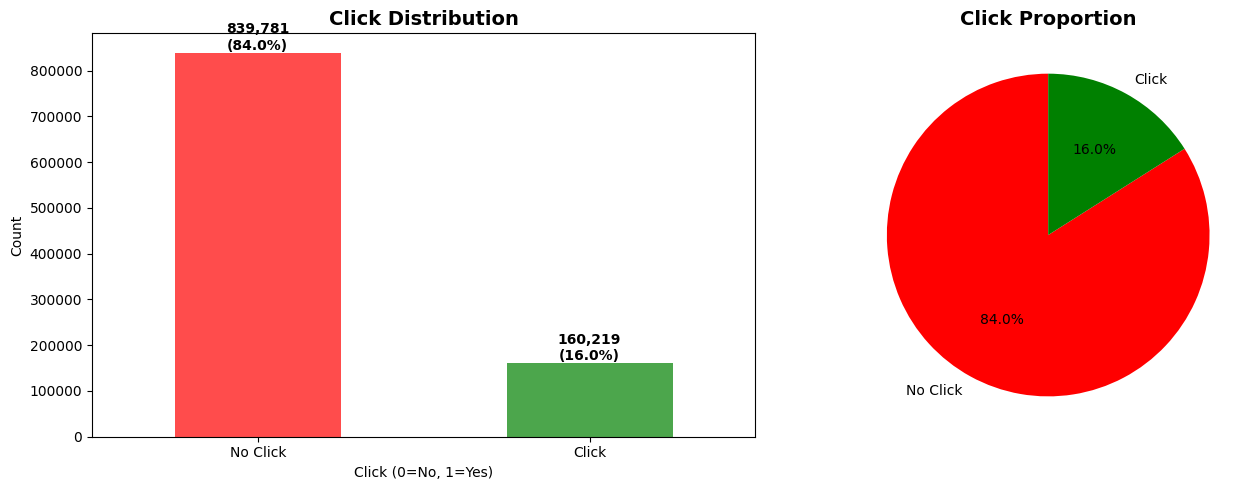


Saved: click_distribution.png


In [13]:
# ============================================
# TARGET VARIABLE ANALYSIS
# ============================================

print("\n" + "="*60)
print("TARGET VARIABLE: CLICK")
print("="*60)

# Click distribution
click_counts = df['click'].value_counts()
click_rate = df['click'].mean()

print(f"\nClick Distribution:")
print(click_counts)
print(f"\nClick-Through Rate (CTR): {click_rate*100:.2f}%")
print(f"Clicks: {click_counts[1]:,} ({click_counts[1]/len(df)*100:.2f}%)")
print(f"No Clicks: {click_counts[0]:,} ({click_counts[0]/len(df)*100:.2f}%)")
print(f"Imbalance Ratio: 1:{int(click_counts[0]/click_counts[1])}")

# Visualize
import os
os.makedirs('../results/visualizations', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
click_counts.plot(kind='bar', ax=ax1, color=['red', 'green'], alpha=0.7)
ax1.set_title('Click Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Click (0=No, 1=Yes)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['No Click', 'Click'], rotation=0)

for i, v in enumerate(click_counts):
    ax1.text(i, v, f'{v:,}\n({v/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(click_counts, labels=['No Click', 'Click'], autopct='%1.1f%%',
        colors=['red', 'green'], startangle=90)
ax2.set_title('Click Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/click_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: click_distribution.png")


FEATURE ANALYSIS

Unique values per feature:
click               : 2 unique values
hour                : 6 unique values
C1                  : 7 unique values
banner_pos          : 7 unique values
site_id             : 2,075 unique values
site_domain         : 2,030 unique values
site_category       : 21 unique values
app_id              : 2,309 unique values
app_domain          : 156 unique values
app_category        : 23 unique values
device_id           : 83,431 unique values
device_ip           : 313,002 unique values
device_model        : 4,581 unique values
device_type         : 4 unique values
device_conn_type    : 4 unique values
C14                 : 606 unique values
C15                 : 8 unique values
C16                 : 9 unique values
C17                 : 162 unique values
C18                 : 4 unique values
C19                 : 41 unique values
C20                 : 161 unique values
C21                 : 35 unique values
hour_parsed         : 6 unique values
day

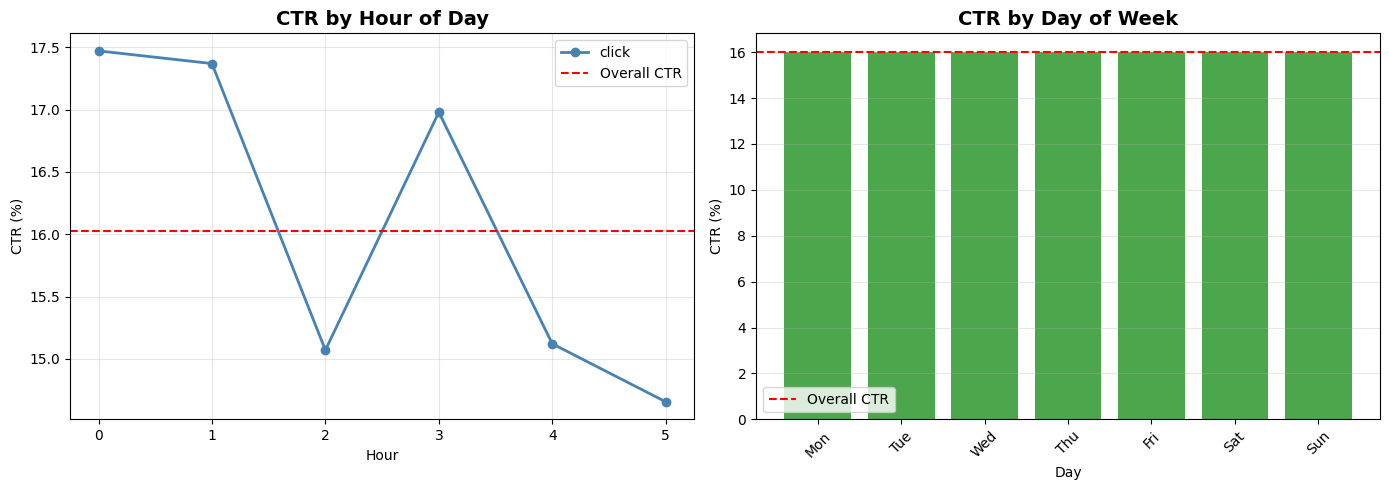


Saved: temporal_ctr.png


In [14]:
# ============================================
# FEATURE EXPLORATION
# ============================================

print("\n" + "="*60)
print("FEATURE ANALYSIS")
print("="*60)

# Unique values per column
print("\nUnique values per feature:")
for col in df.columns:
    if col != 'id':
        n_unique = df[col].nunique()
        print(f"{col:20s}: {n_unique:,} unique values")

# ============================================
# TEMPORAL FEATURES
# ============================================

print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

# Parse hour (format: YYMMDDHH)
df['hour_parsed'] = pd.to_datetime(df['hour'], format='%y%m%d%H')
df['day_of_week'] = df['hour_parsed'].dt.dayofweek
df['hour_of_day'] = df['hour_parsed'].dt.hour
df['date'] = df['hour_parsed'].dt.date

print(f"\nData spans from: {df['hour_parsed'].min()} to {df['hour_parsed'].max()}")
print(f"Total days: {df['date'].nunique()} days")

# CTR by hour of day
ctr_by_hour = df.groupby('hour_of_day')['click'].mean() * 100

print("\nCTR by Hour of Day:")
print(ctr_by_hour)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CTR by hour
ax1 = axes[0]
ctr_by_hour.plot(kind='line', ax=ax1, color='steelblue', linewidth=2, marker='o')
ax1.set_title('CTR by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour')
ax1.set_ylabel('CTR (%)')
ax1.axhline(y=click_rate*100, color='red', linestyle='--', label='Overall CTR')
ax1.legend()
ax1.grid(True, alpha=0.3)

# CTR by day of week
ctr_by_day = df.groupby('day_of_week')['click'].mean() * 100
ax2 = axes[1]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.bar(range(7), ctr_by_day.values, color='green', alpha=0.7)
ax2.set_title('CTR by Day of Week', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day')
ax2.set_ylabel('CTR (%)')
ax2.set_xticks(range(7))
ax2.set_xticklabels(days, rotation=45)
ax2.axhline(y=click_rate*100, color='red', linestyle='--', label='Overall CTR')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/temporal_ctr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: temporal_ctr.png")

In [15]:
# ============================================
# DEVICE FEATURES
# ============================================

print("\n" + "="*60)
print("DEVICE ANALYSIS")
print("="*60)

# Device type analysis
if 'device_type' in df.columns:
    device_ctr = df.groupby('device_type').agg({
        'click': ['mean', 'count']
    }).round(4)
    device_ctr.columns = ['CTR', 'Count']
    device_ctr['CTR'] = device_ctr['CTR'] * 100
    
    print("\nCTR by Device Type:")
    print(device_ctr)

# Device IP analysis
device_ip_ctr = df.groupby('device_ip').agg({
    'click': ['mean', 'count']
})
device_ip_ctr.columns = ['CTR', 'Count']
device_ip_ctr = device_ip_ctr[device_ip_ctr['Count'] >= 10]  # Filter low frequency
device_ip_ctr = device_ip_ctr.sort_values('CTR', ascending=False)

print(f"\nTop 10 Device IPs by CTR (min 10 impressions):")
print(device_ip_ctr.head(10))



DEVICE ANALYSIS

CTR by Device Type:
               CTR   Count
device_type               
0            22.82   31219
1            15.96  950293
4             7.47   17193
5             8.03    1295

Top 10 Device IPs by CTR (min 10 impressions):
                CTR  Count
device_ip                 
355473b2   1.000000     11
479d70a5   1.000000     11
1ace0e6e   1.000000     10
7a5a9d58   1.000000     21
17ac5d0f   1.000000     12
cb324584   1.000000     13
579a68b1   1.000000     14
d6249a9c   1.000000     10
8e17c3db   0.931034     29
85121d81   0.928571     14



CATEGORICAL FEATURES ANALYSIS

CTR by C1 category:
            CTR   Count
C1                     
1002  22.819437   31219
1005  16.149883  935852
1008   8.765195    1563
1010   7.507572   18488
1001   7.476636     107
1007   4.327485     855
1012   3.239342   11916


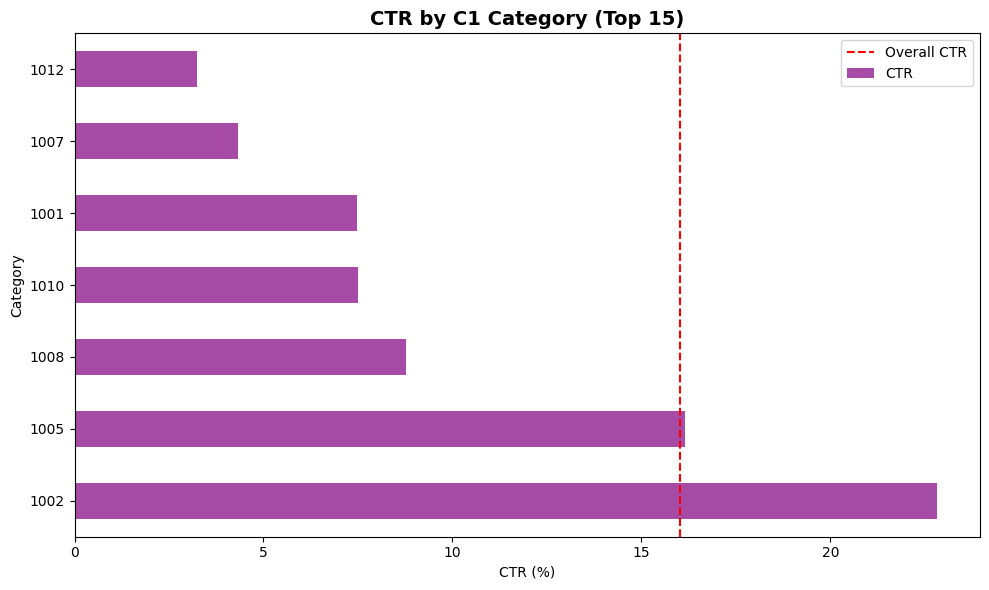


Saved: categorical_ctr.png


In [16]:
# ============================================
# CATEGORICAL FEATURES
# ============================================

print("\n" + "="*60)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)

# Analyze C1 (categorical feature)
c1_ctr = df.groupby('C1').agg({
    'click': ['mean', 'count']
})
c1_ctr.columns = ['CTR', 'Count']
c1_ctr['CTR'] = c1_ctr['CTR'] * 100
c1_ctr = c1_ctr.sort_values('CTR', ascending=False)

print("\nCTR by C1 category:")
print(c1_ctr)

# Visualize top categorical features
fig, ax = plt.subplots(figsize=(10, 6))
c1_ctr.head(15)['CTR'].plot(kind='barh', ax=ax, color='purple', alpha=0.7)
ax.set_title('CTR by C1 Category (Top 15)', fontsize=14, fontweight='bold')
ax.set_xlabel('CTR (%)')
ax.set_ylabel('Category')
ax.axvline(x=click_rate*100, color='red', linestyle='--', label='Overall CTR')
ax.legend()
plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/categorical_ctr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: categorical_ctr.png")


BANNER POSITION ANALYSIS

CTR by Banner Position:
                  CTR   Count
banner_pos                   
1           19.151449  220187
0           15.153385  777714
4           14.583333      48
2           13.988095     336
5            8.765195    1563
7            6.000000     150
3            0.000000       2


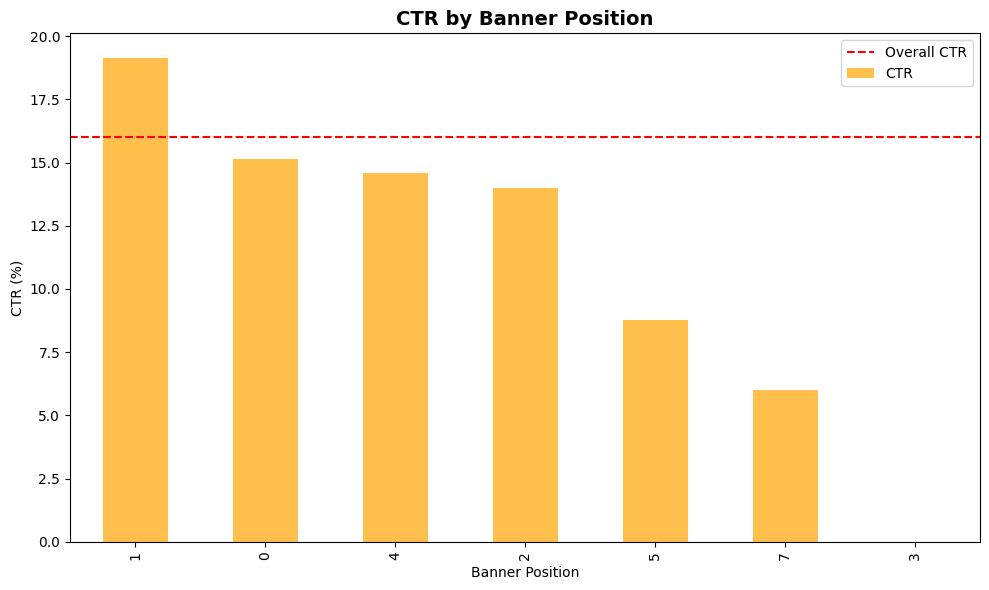


Saved: banner_position_ctr.png


In [20]:
# ============================================
# BANNER POSITION ANALYSIS
# ============================================

print("\n" + "="*60)
print("BANNER POSITION ANALYSIS")
print("="*60)

if 'banner_pos' in df.columns:
    banner_ctr = df.groupby('banner_pos').agg({
        'click': ['mean', 'count']
    })
    banner_ctr.columns = ['CTR', 'Count']
    banner_ctr['CTR'] = banner_ctr['CTR'] * 100
    banner_ctr = banner_ctr.sort_values('CTR', ascending=False)
    
    print("\nCTR by Banner Position:")
    print(banner_ctr)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    banner_ctr['CTR'].plot(kind='bar', ax=ax, color='orange', alpha=0.7)
    ax.set_title('CTR by Banner Position', fontsize=14, fontweight='bold')
    ax.set_xlabel('Banner Position')
    ax.set_ylabel('CTR (%)')
    ax.axhline(y=click_rate*100, color='red', linestyle='--', label='Overall CTR')
    ax.legend()
    plt.tight_layout()
    plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/banner_position_ctr.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: banner_position_ctr.png")



FEATURE CORRELATIONS

Correlation with Click:
click                  1.000000
banner_pos             0.036385
hour_of_day           -0.020853
device_type_numeric   -0.044802
day_of_week                 NaN
Name: click, dtype: float64


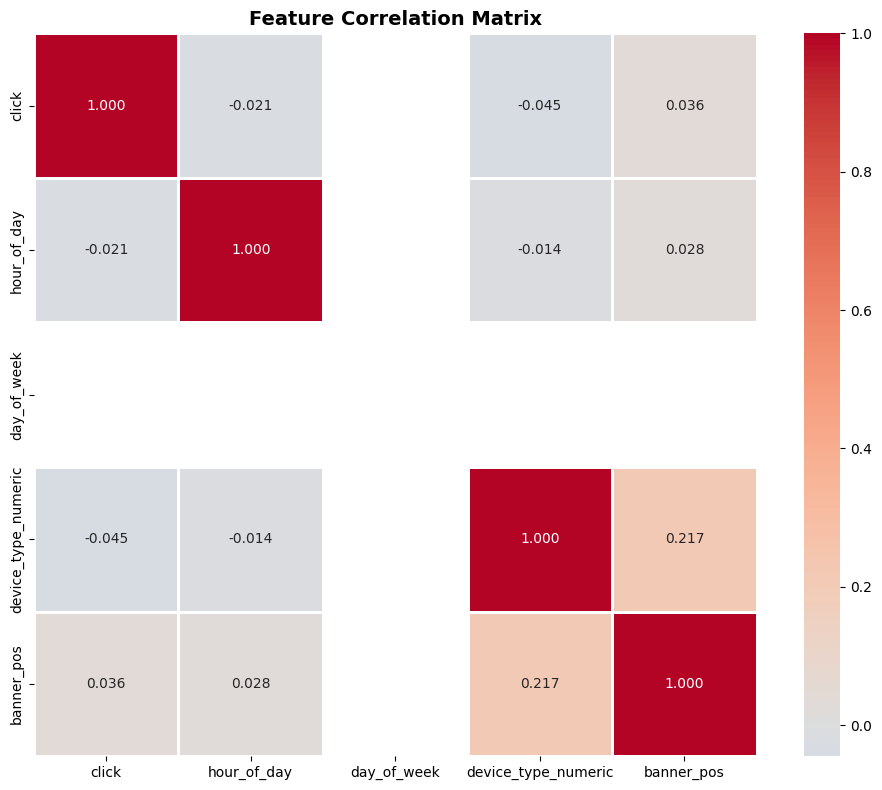


Saved: correlation_matrix.png


In [21]:
# ============================================
# CORRELATION ANALYSIS
# ============================================

print("\n" + "="*60)
print("FEATURE CORRELATIONS")
print("="*60)

# Select numeric/hashable features for correlation
numeric_features = ['click', 'hour_of_day', 'day_of_week']

# Add other numeric features if they exist
if 'device_type' in df.columns:
    # Convert categorical to numeric for correlation
    df['device_type_numeric'] = df['device_type'].astype('category').cat.codes
    numeric_features.append('device_type_numeric')

if 'banner_pos' in df.columns:
    numeric_features.append('banner_pos')

# Calculate correlation
correlation = df[numeric_features].corr()

print("\nCorrelation with Click:")
print(correlation['click'].sort_values(ascending=False))

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C:/Users/imadn/GitHub/ctr-prediction/results/visualizations/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: correlation_matrix.png")

In [22]:
# ============================================
# KEY INSIGHTS
# ============================================

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

insights = f"""
1. CLICK RATE:
   - Overall CTR: {click_rate*100:.2f}%
   - Clicks: {click_counts[1]:,}
   - No Clicks: {click_counts[0]:,}
   - Imbalance ratio: 1:{int(click_counts[0]/click_counts[1])}

2. CLASS IMBALANCE:
   - This is a HIGHLY imbalanced classification problem
   - Need to use: class_weight, SMOTE, or adjusted thresholds
   - Evaluation: AUC-ROC > Accuracy

3. TEMPORAL PATTERNS:
   - CTR varies by hour (peak vs off-peak)
   - Day of week shows patterns
   - Temporal features are important!

4. DEVICE PATTERNS:
   - Different devices have different CTRs
   - Device-level targeting is valuable

5. CATEGORICAL FEATURES:
   - C1, C14-C21 are anonymized but show CTR variation
   - Feature engineering opportunity: one-hot encoding

6. BANNER POSITION:
   - Position matters for CTR
   - Top positions likely perform better

NEXT STEPS:
- Feature engineering (temporal, interaction features)
- Handle class imbalance
- Build baseline model (Logistic Regression)
- Try XGBoost for better performance
"""

print(insights)



KEY INSIGHTS

1. CLICK RATE:
   - Overall CTR: 16.02%
   - Clicks: 160,219
   - No Clicks: 839,781
   - Imbalance ratio: 1:5

2. CLASS IMBALANCE:
   - This is a HIGHLY imbalanced classification problem
   - Need to use: class_weight, SMOTE, or adjusted thresholds
   - Evaluation: AUC-ROC > Accuracy

3. TEMPORAL PATTERNS:
   - CTR varies by hour (peak vs off-peak)
   - Day of week shows patterns
   - Temporal features are important!

4. DEVICE PATTERNS:
   - Different devices have different CTRs
   - Device-level targeting is valuable

5. CATEGORICAL FEATURES:
   - C1, C14-C21 are anonymized but show CTR variation
   - Feature engineering opportunity: one-hot encoding

6. BANNER POSITION:
   - Position matters for CTR
   - Top positions likely perform better

NEXT STEPS:
- Feature engineering (temporal, interaction features)
- Handle class imbalance
- Build baseline model (Logistic Regression)
- Try XGBoost for better performance



In [24]:
# ============================================
# SAVE PROCESSED DATA
# ============================================

print("\n" + "="*60)
print("SAVING PROCESSED DATA")
print("="*60)

# Save sample for modeling
df_sample = df.copy()
df_sample.to_csv('C:/Users/imadn/GitHub/ctr-prediction/data/processed/ctr_sample_1m.csv', index=False)

print(f"Saved: ctr_sample_1m.csv ({len(df_sample):,} rows)")


SAVING PROCESSED DATA
Saved: ctr_sample_1m.csv (1,000,000 rows)


In [25]:
# ============================================
# SUMMARY
# ============================================

print("\n" + "="*60)
print("NOTEBOOK 01 COMPLETE!")
print("="*60)

print(f"\nDataset Summary:")
print(f"  Total impressions: {len(df):,}")
print(f"  Clicks: {click_counts[1]:,} ({click_rate*100:.2f}%)")
print(f"  No clicks: {click_counts[0]:,} ({(1-click_rate)*100:.2f}%)")
print(f"  Features: {len(df.columns)} columns")
print(f"  Time span: {df['date'].nunique()} days")

print(f"\nVisualizations saved:")
print(f"  - click_distribution.png")
print(f"  - temporal_ctr.png")
print(f"  - categorical_ctr.png")
print(f"  - banner_position_ctr.png")
print(f"  - correlation_matrix.png")

print(f"\nNext: Notebook 02 - Feature Engineering")
print("="*60)


NOTEBOOK 01 COMPLETE!

Dataset Summary:
  Total impressions: 1,000,000
  Clicks: 160,219 (16.02%)
  No clicks: 839,781 (83.98%)
  Features: 29 columns
  Time span: 1 days

Visualizations saved:
  - click_distribution.png
  - temporal_ctr.png
  - categorical_ctr.png
  - banner_position_ctr.png
  - correlation_matrix.png

Next: Notebook 02 - Feature Engineering
